In [65]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 130)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [87]:
id_train = train['SK_ID_CURR']

In [90]:
train.drop('SK_ID_CURR' , axis=1 , inplace=True)

In [2]:
train = pd.read_csv(r"C:\Users\joao\Desktop\Análise risco de crédito\application_train.csv")

In [3]:
var_para_excluir = ['APARTMENTS_MEDI',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_MODE',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_MODE',
 'LANDAREA_AVG',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MEDI',
 'NONLIVINGAREA_MODE']

In [4]:
novas_colunas = train.columns[~(np.in1d(train.columns , var_para_excluir))]

In [5]:
train = train[novas_colunas]

In [6]:
train_numerico = train.select_dtypes(include=[np.number])

Como os valores são provavelmente positivas por se tratar de caracteristicas da pessoa como idade e etc. Verificamos as colunas que são negativas para confirmar que realmente se tratam de valores negativas a priori

In [43]:
train_numerico.apply(lambda x: (x<0).any()).sort_values(ascending=False)[:6] #tabela 4

DAYS_LAST_PHONE_CHANGE     True
DAYS_BIRTH                 True
DAYS_EMPLOYED              True
DAYS_REGISTRATION          True
DAYS_ID_PUBLISH            True
SK_ID_CURR                False
dtype: bool

a tabela confirma anomalias nas colunas com relação a dias. Vamos verificar essas colunas para formatação e verificação. E
vamos verificar se há mais algum erro, já que houve um erro na questão do sinal dos valores.

In [8]:
mask_days = train_numerico.apply(lambda x: (x<0).any()).sort_values(ascending=False).index[:5]

corrigindo os valores para positivo por se tratar de dias

In [9]:
train[mask_days] = np.absolute(train[mask_days])

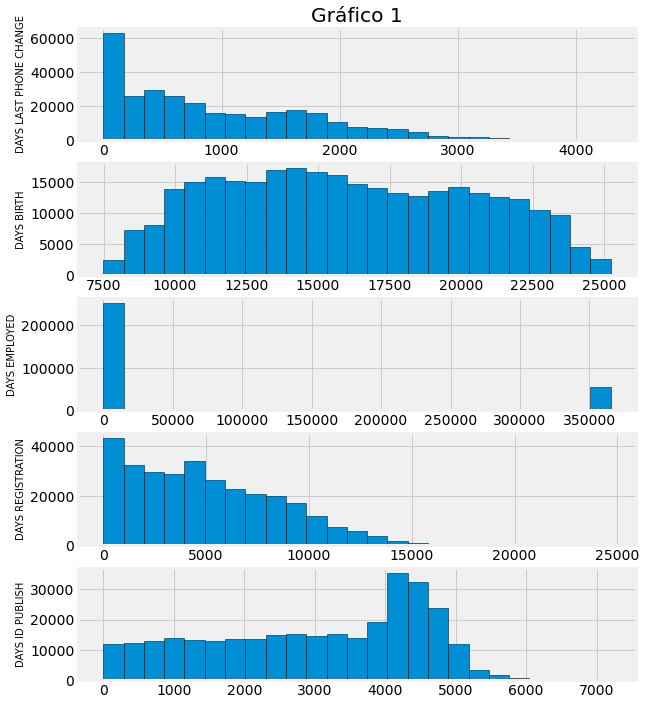

In [10]:
plt.figure(figsize = (10, 12))
plt.style.use('fivethirtyeight')

for i , k in enumerate(mask_days):
    plt.subplot(5, 1, i + 1)
    plt.ylabel(' '.join(mask_days[i].split('_')),fontsize = 10);                                                                                                    
    plt.hist(train[k], edgecolor = 'k', bins = 25)
    if i == 0:
        plt.title('Gráfico 1')

O histograma relativo a dias empregado(days employed) parece apresentar uma anomalia por ter uma concentração de dias em torno de 350000, o que daria 1000 anos

In [11]:
365243/365

1000.6657534246575

In [12]:
train['DAYS_EMPLOYED'].value_counts()

365243    55374
200         156
224         152
230         151
199         151
          ...  
13961         1
11827         1
10176         1
9459          1
8694          1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

Vamos marcar essa anomalia com um número arbitrário que indique isso para lidarmos com isso no futuro, o numero escolhido para marcar anomalias será -999999, por ser improvavel que alguma coluna assuma esse valor

In [13]:
train.loc[train['DAYS_EMPLOYED'] > 300000 , 'DAYS_EMPLOYED'] = -999999

In [14]:
train['DAYS_EMPLOYED'].value_counts()

-999999    55374
 200         156
 224         152
 230         151
 199         151
           ...  
 13961         1
 11827         1
 10176         1
 9459          1
 8694          1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

Pelo gráfico 1 é possivel ver que as outras colunas parecem se comportar de maneira usual pelos valores da distribuição estarem abaixo dos valores de dias de nascimento, já que, por exemplo, dias da ultima mudança de telefone (days last phone change) precisa necessariamente ser menor que os dias de nascimento.

Resumo do código a seguir:

1° verificamos as colunas que apresentam um valor que tem uma frequência acima de 99.9% em todas observações da coluna. Pouca variabilidade desses valores muita das vezes significa um poder explicativo baixo.

In [39]:
def pouca_variabilidade(x):
    tamanho = len(x[~(x.isnull())])
    index = x.value_counts().values[0]
    var = x.value_counts().index[0]
    if index > tamanho*0.999:
        return (index/tamanho)
    else:
        return False

Função para capitar a pouca variabilidade das colunas. Se uma coluna tem um valor frequente maior que 99.9%, a linha de código abaixo apontará a frequencia dessa valor na coluna. Pouca variabilidade um poder explicativo pobre.

Uma forma de enxergar esse fato é imaginar uma coluna que assume sempre o valor 1, como essa coluna assume sempre o valor 1 ela não teria poder discriminatório para diferenciar o alvo em si.

In [42]:
train.agg(pouca_variabilidade).sort_values(ascending=False)[:10]

FLAG_MOBIL          0.999997
FLAG_DOCUMENT_12    0.999993
FLAG_DOCUMENT_10    0.999977
FLAG_DOCUMENT_2     0.999958
FLAG_DOCUMENT_4     0.999919
FLAG_DOCUMENT_7     0.999808
FLAG_DOCUMENT_17    0.999733
FLAG_DOCUMENT_21    0.999665
FLAG_DOCUMENT_20    0.999493
FLAG_DOCUMENT_19    0.999405
dtype: object

Todas Colunas acima possuem um valor com frequência acima de 99.9%

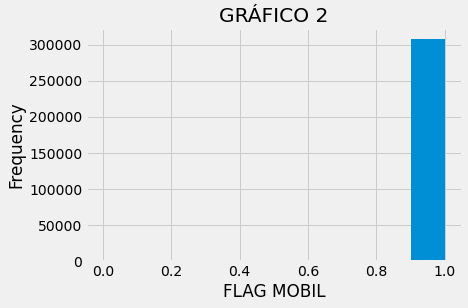

In [48]:
train['FLAG_MOBIL'].plot.hist(title = 'GRÁFICO 2');
plt.xlabel('FLAG MOBIL');

In [51]:
np.abs(train.corr()['TARGET']).sort_values(ascending=True)[:4] #tabela 5

FLAG_DOCUMENT_20    0.000215
FLAG_DOCUMENT_5     0.000316
FLAG_CONT_MOBILE    0.000370
FLAG_MOBIL          0.000534
Name: TARGET, dtype: float64

Perceba pelo Gráfico 2 que a coluna flag mobil tem seus valores concentrados em 1. 

Perceba também pela tabela 5 que a coluna FLAG_MOBIL é a quarta menos correlacionada com a variável dependente, 'TARGET', confirmando seu pouco poder de explicação.

Podemos então excluir essas variáveis para ter uma análise futura mais concentrada nos valores que realmente são importantes para explicar o modelo.

In [61]:
colunas_novas = train.columns[~(np.in1d(train.columns , train.agg(pouca_variabilidade).sort_values(ascending=False)[:10].index))]

In [75]:
train = train[colunas_novas].copy()

Detecção de outliers:
A detecção de outliers padrão se baseia na formula de quartis. 

Mas pelo histórico estudado dessa amostra é possível ver que muitas colunas possuem somente o valor 0 ou 1, e o que isso implica? 

Implica que não será possivel detectar outliers pela formula comum. Se uma coluna possue muitos valores 0 tanto o primeiro quanto o terceiro quartil terão valores igual a 0.

vamos filtrar essas colunas.

In [70]:
def numero_de_valores(x):
    return len(x.value_counts()) > 20

Primeiro pegamos as colunas que possuem mais de 20 valores diferentes.

In [98]:
colunas_p_out = train.select_dtypes(include=np.number).agg(numero_de_valores).sort_values(ascending=False)[:40].index

In [99]:
train[colunas_p_out]

,ENTRANCES_AVG,NONLIVINGAREA_AVG,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_POPULATION_RELATIVE,HOUR_APPR_PROCESS_START
0,0.0690,0.0000,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0833,0.1250,...,202500.0,406597.5,24700.5,351000.0,9461,637,3648.0,2120,0.018801,10
1,0.0345,0.0098,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.2917,0.3333,...,270000.0,1293502.5,35698.5,1129500.0,16765,1188,1186.0,291,0.003541,11
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67500.0,135000.0,6750.0,135000.0,19046,225,4260.0,2531,0.010032,9
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,135000.0,312682.5,29686.5,297000.0,19005,3039,9833.0,2437,0.008019,17
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,121500.0,513000.0,21865.5,513000.0,19932,3038,4311.0,3458,0.028663,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.1034,0.1095,0.2021,0.0887,0.9876,0.8300,0.0202,0.22,0.6042,0.2708,...,157500.0,254700.0,27558.0,225000.0,9327,236,8456.0,1982,0.032561,15
307507,0.1034,0.0000,0.0247,0.0435,0.9727,0.6260,0.0022,0.00,0.0833,0.1250,...,72000.0,269550.0,12001.5,225000.0,20775,-999999,4388.0,4090,0.025164,8
307508,0.2069,0.0000,0.1031,0.0862,0.9816,0.7484,0.0123,0.00,0.1667,0.2083,...,153000.0,677664.0,29979.0,585000.0,14966,7921,6737.0,5150,0.005002,9
307509,0.0690,NaN,0.0124,NaN,0.9771,NaN,NaN,NaN,0.0417,NaN,...,171000.0,370107.0,20205.0,319500.0,11961,4786,2562.0,931,0.005313,9


Agora vamos pegar as colunas que possuem um valor 10 vezes maior que sua média e verificar uma possível anomalia

In [219]:
def max_10(x):
    return np.abs(x) > 10*x.mean()

In [154]:
colunas_max_10 = train[colunas_p_out].agg(max_10).any().sort_values(ascending=False)[:14].index

In [171]:
def boxplot(x,**kwargs):
    sns.boxplot(x=x)
    x=plt.xticks(rotation=90)
    

In [173]:
sns.set_theme(style="darkgrid")

In [227]:
train_melt = pd.melt(train[colunas_max_10]).rename({'value' : 'valor' , 'variable' : 'coluna'} , axis =1)
train_melt['coluna'] = train_melt['coluna'].apply(lambda x: ' '.join(x.split('_')))

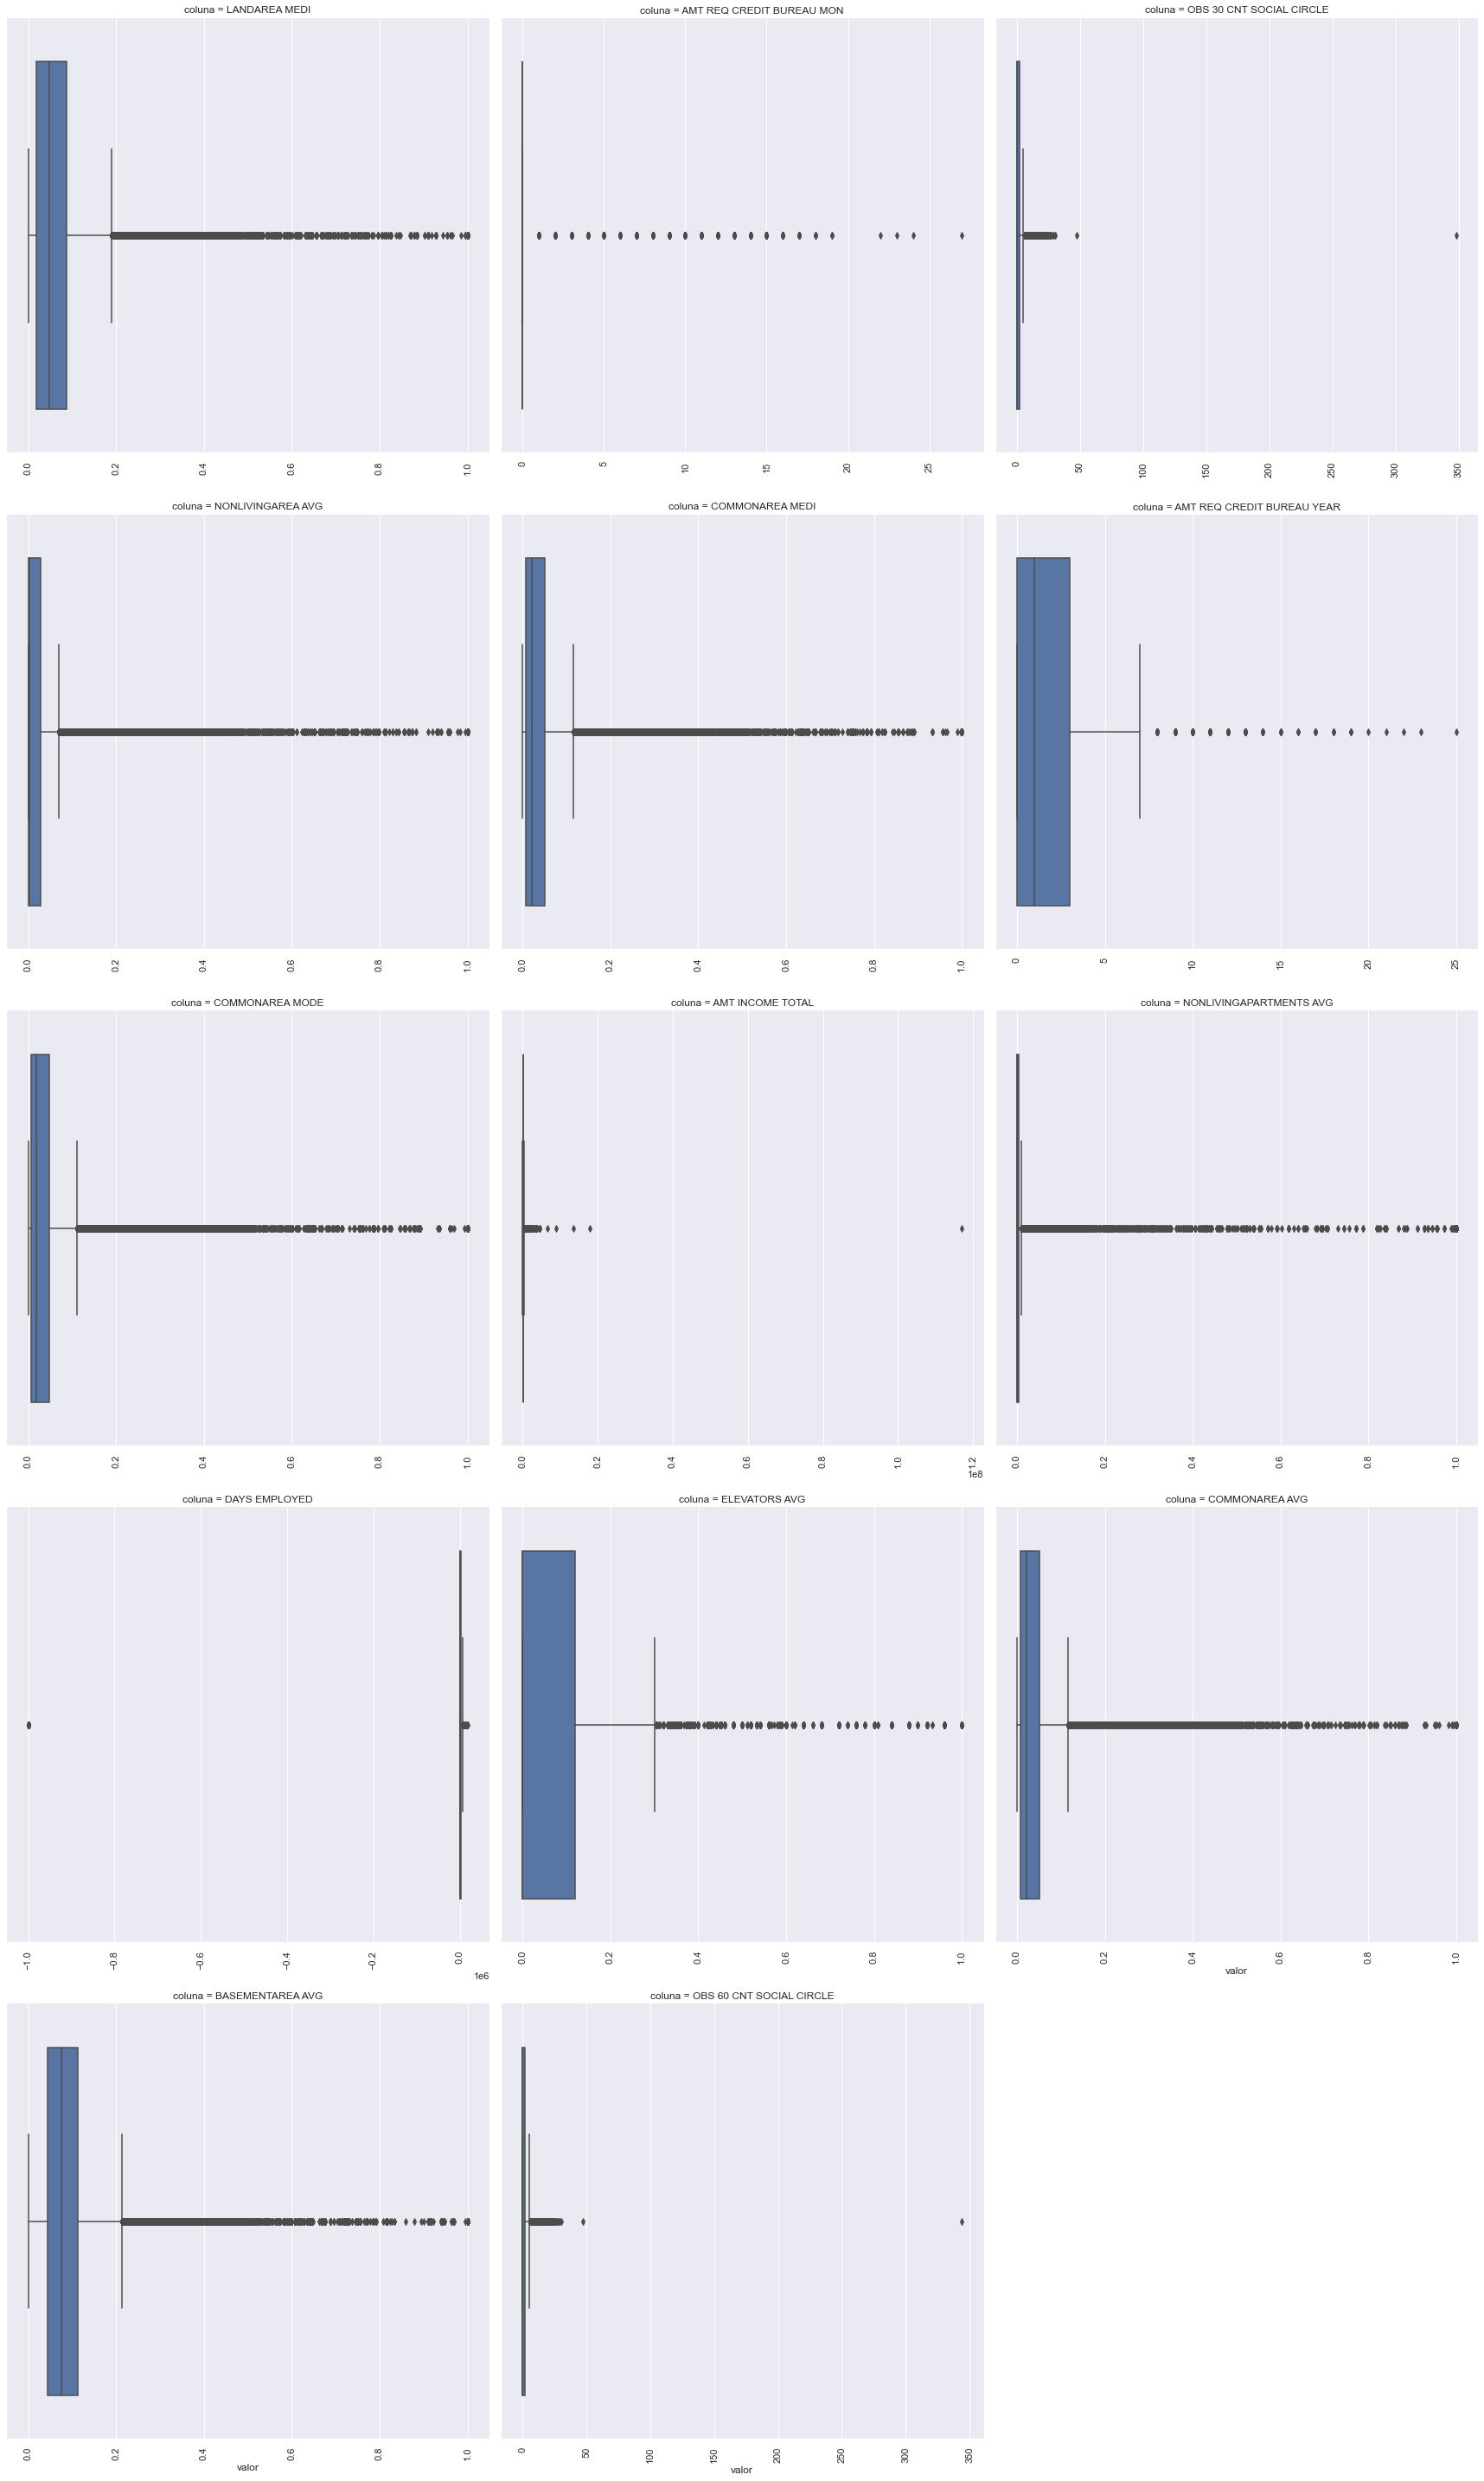

In [229]:
g=sns.FacetGrid(train_melt, col="coluna",  col_wrap=3, sharex=False, sharey=False,size=8)
g= g.map(boxplot , 'valor')

Primeiramente, pela análise gráfica é possivel perceber uma semelhança muito grande entre a coluna 'OBS_60_CNT_SOCIAL_CIRCLE' e 'OBS_30_CNT_SOCIAL_CIRCLE', até seus outliers. Vamos verificar a correlação entre essas duas colunas:

In [236]:
train['OBS_60_CNT_SOCIAL_CIRCLE'].corr(train['OBS_30_CNT_SOCIAL_CIRCLE'])

0.9984895425108745

Confirmado. Essas duas colunas possuem uma colinearidade muito alta. Não é necessário manter essas duas colunas para prever o modelo, já que as duas vão trazer o mesmo nível de informação.

Vamos aproveitar para detectar alto nível de correlação entre as colunas

In [286]:
corr_frame = pd.DataFrame()
corr_colunas = []
corr_valores = []
for i in train.select_dtypes(include=np.number).columns:
    var_corr = np.abs(train.corr()[i].sort_values(ascending=False))[1:]
    mask = var_corr.values > 0.99
    if len(var_corr[mask].index)> 0:
        corr_colunas.append(' '.join(var_corr[mask].index.values))
        corr_valores.append(' '.join(var_corr[mask].values.astype(str)))
    else:
        corr_colunas.append('sem_corr')
        corr_valores.append(np.nan)
corr_frame['colunas_pesquisadas'] = corr_colunas
corr_frame['valores'] = corr_valores
corr_frame['coluna_avaliada'] = train.select_dtypes(include=np.number).columns

In [304]:
corr_frame.sort_values('valores').iloc[:10:2,0:]

,colunas_pesquisadas,valores,coluna_avaliada
32,YEARS_BEGINEXPLUATATION_MEDI,0.9938254172943787,YEARS_BEGINEXPLUATATION_AVG
34,COMMONAREA_MEDI,0.9959780551910289,COMMONAREA_AVG
51,OBS_60_CNT_SOCIAL_CIRCLE,0.998489542510996,OBS_30_CNT_SOCIAL_CIRCLE
33,YEARS_BUILD_MEDI,0.9984946631734793,YEARS_BUILD_AVG
8,FLAG_EMP_PHONE,0.9998525584160275,DAYS_EMPLOYED


In [307]:
train['YEARS_BUILD_AVG'] - train['YEARS_BUILD_MEDI']

0        -0.0051
1        -0.0027
2            NaN
3            NaN
4            NaN
           ...  
307506   -0.0023
307507   -0.0050
307508   -0.0034
307509       NaN
307510       NaN
Length: 307511, dtype: float64

In [308]:
(train['YEARS_BUILD_AVG'] - train['YEARS_BUILD_MEDI']).value_counts()

-0.0035    5233
-0.0024    2911
-0.0025    2790
-0.0026    2746
-0.0036    2713
           ... 
 0.0612       1
 0.0003       1
 0.0275       1
-0.0392       1
 0.0844       1
Length: 852, dtype: int64

In [309]:
train

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
